In [4023]:
# -*- coding: utf-8 -*-
"""
Created on Tues Dec  5 15:17:49 2023

@author: lu516e
"""

from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, ElasticNet

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             auc, 
                             roc_auc_score,
                             roc_curve,
                             confusion_matrix)

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, 
                                   PolynomialFeatures, StandardScaler,
                                   label_binarize)
from scipy.sparse import csr_matrix

from skopt import BayesSearchCV
from skopt.space import Real,Categorical,Integer
#import warnings as wrn
from pdpbox import pdp



    
    

In [4024]:
def dropFeatures(df_,feats_to_drop,drop_outputs=False):
    #INCLUDE ALL INPUT FEATURES IN THE X DATAFRAME

    if drop_outputs:
        #OUTPUT LABELS
        output_columns = [col.lower() for col in getOutputFeatures()]
        feats_to_drop.extend(output_columns)
    
    return df_.drop(feats_to_drop,axis=1)
    

def preprocessInput(df_,train=False):
    #MAKE LISTINGID INDEX COLUMN
    temp = df_.copy()
    temp.set_index('ListingID',inplace=True)
    temp.columns = temp.columns.str.lower()
    temp = dropFeatures(temp,drop_outputs=train)
    temp,cat_cols,num_cols = arbitrateFeatuteTypes(temp)
    
    print("SCALING NUMERICAL VALUES.....")
    df_num = zScoreTransform(temp, num_cols)
    
    print("ENCODING......")
    df_cat = labelEncode(temp,cat_cols)
    
    drops = num_cols + cat_cols
    
    df_notes = tf_idfTokenizer(temp["vehsellernotes"])
    
    drops.append("vehsellernotes")
    temp.drop(drops,axis=1,inplace=True)
    
    #print(temp.columns)
    df_num = pd.DataFrame(df_num)
    df_cat = pd.DataFrame(df_cat)
    df_notes = pd.DataFrame(df_notes)
    print(df_num.index)
    print(df_cat.index)
    print(df_notes.index)
    #TODO
    #FEATS,vehhistory, vehsellernotes
    concat_df = pd.concat([df_num,df_cat,df_notes],axis=1)
    concat_df.index = df_.ListingID
    print(concat_df.shape)
    #oncat_df.columns = drops
    
    return concat_df

    
def getOutputFeatures():
    return ['Vehicle_Trim', 'Dealer_Listing_Price']


def arbitrateFeatuteTypes(df_):
    cat_feats = []
    num_feats = []
    for col in df_.columns:
        if df_[col].dtype == 'object':
            print("OBJECT COL: ",col)
            # Categorical column - fill missing values with 'Unknown'
            df_[col].fillna('Unknown', inplace=True)
            cat_feats.append(col)        
        else:
            print("Numerical col: ",col)
            # Numerical column - fill missing values with mean
            df_[col].fillna(df_[col].mode(), inplace=True)
            num_feats.append(col)
    return df_,cat_feats,num_feats



def oHotEncode(df):
    encoder = OneHotEncoder()
    encoded_mat = encoder.fit_transform(df.values.reshape(-1,1))
    return pd.DataFrame(encoded_mat.toarray(),
                          columns=encoder.get_feature_names_out(['feature']),
                          index=df.index)
    
def zScoreTransform(col):
    return np.divide(np.subtract(col,col.mean()),col.std())
    
def tf_idfTokenizer(df_,max_doc_freq,max_feats):
    tfidf = TfidfVectorizer(max_df=max_doc_freq,max_features=max_feats)
    tf_mat = tfidf.fit_transform(df_)
    return pd.DataFrame(tf_mat.toarray(),
                          columns=tfidf.get_feature_names_out(['feature']),
                          index=df_.index)

def setFeatPtr(data,index):
    return data.iloc[:,index],data.columns[index]

def plotDist(data,title):
    # Plotting a histogram of frequencies
    fig, ax = plt.subplots()
    sns.histplot(data, kde=True, ax=ax)
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    plt.show()

def categorize_train(phrase, awd_pattern, fwd_pattern, wd_pattern):
    if re.search(awd_pattern, phrase) and re.search(wd_pattern, phrase):
        return 'hybrid'
    elif re.search(awd_pattern, phrase):
        return 'awd'
    elif re.search(fwd_pattern, phrase):
        return 'fwd'
    elif re.search(wd_pattern, phrase):
        return '4wd'
    else:
        return 'Unknown'

def handleDriveTrain(df):
    df = df.str.lower()
    awd_pattern = re.compile(r'awd|all', flags=re.IGNORECASE)
    fwd_pattern = re.compile(r'fwd|front', flags=re.IGNORECASE)
    wd_pattern = re.compile(r'4x4|4wd|four\s?WHEEL\s?DRIVE\b', flags=re.IGNORECASE)
    return df.apply(categorize_train, args=(awd_pattern, fwd_pattern, wd_pattern))

# Function extracts engine size and configuration
def categorize_engine(phrase):
    engine_size_match = re.search(r'\b\d+(\.\d+)?\s*L\b', phrase)  # Matches pattern with number (with or without decimal) followed by L
    config_match = re.search(r'V[-]?6|V[-]?8|\b\d\s*cylinder|\b6\s*cylinde', phrase, re.IGNORECASE)  # Matches V6, V-6, V8, V-8, or a number followed by cylinders

    if engine_size_match:
        engine_size = float(re.search(r'\d+(\.\d+)?', engine_size_match.group()).group())  # Extracts engine size
        size_category = engine_size  # Assigning the engine size directly as the size category
    else:
        size_category = 0

    if config_match:
        config_str = config_match.group().upper()
        config = 6 if '6' in config_str else 8  # Assign 6 or 8 based on the presence of 'Vx' or 'Cyclinders'
    else:
        config = 0

    return size_category, config

def handleVehEngine(df):
    extracted_info = df.apply(categorize_engine)
    # Convert the extracted information into a DataFrame
    df = pd.DataFrame(extracted_info.tolist(), columns=['EngineSize', 'Cylinders'], index=df.index)
    return df

def handleVehHistory(df):
    # List of unique phrases
    unique_phrases = [
        'Accident(s) Reported',
        'Buyback Protection Eligible',
        'Non-Personal Use Reported',
        'Title Issue(s) Reported'
    ]
    df = df.str.strip()
    # Applies one-hot encoding to the 'History' column based on the unique phrases
    encoded_df = df.str.get_dummies(',').reindex(columns=unique_phrases, fill_value=0)
    # Checks if all columns for the specified phrases contain zeros and create a 'None of the above' column
    encoded_df['None of the above'] = (encoded_df.sum(axis=1) == 0).astype(int)
    return encoded_df

def handleExtColors(df_):
    common_colors = ['Black', 'Blue', 'Brown', 'Gray', 'Green', 'Steel', 'Metallic','Pearlcoat', 'Clearcoat',
                     'Charcoal','Granite', 'Red', 'Silver', 'White']
    silver_colors = ['Gray', 'Steel', 'Charcoal', 'Silver']
    
    temp = pd.DataFrame(index=df_.index)
    for color in common_colors:
        temp[f'{color}'] = df_.str.contains(color, case=False).astype(int)

    # Grouping similar silver colors into a single 'Silver' category
    temp['Silver'] = df_.str.contains('|'.join(silver_colors), case=False).astype(int)
    temp.drop([col for col in silver_colors if col != 'Silver'], axis=1, inplace=True)
    
    # Populates a 'None' category if none of the common colors are present
    temp['None'] = 1 - temp[[f'{color}' for color in temp.columns]].max(axis=1)
    
    return temp

def handleIntColors(df_):
    common_colors = ['Black', 'Blue', 'Brown', 'Gray', 'Steel', 'Beige', 'leather','trim',
                     'Charcoal','Red', 'Silver', 'Frost','Maple','Tan','Cirrus','carbon','plum']
    silver_colors = ['Gray', 'Steel', 'Charcoal', 'Silver']
    temp = pd.DataFrame(index=df_.index)
    for color in common_colors:
        temp[f'{color}'] = df_.str.contains(color, case=False).astype(int)

    # Grouping similar silver colors into a single 'Silver' category
    temp['Silver'] = df_.str.contains('|'.join(silver_colors), case=False).astype(int)
    temp.drop([col for col in silver_colors if col != 'Silver'], axis=1, inplace=True)
    
    # Populates a 'None' category if none of the common colors are present
    temp['None'] = 1 - temp[[f'{color}' for color in temp.columns]].max(axis=1)
    
    return temp

In [4025]:
#Initialize training and test dataframes

df_train = pd.read_csv('Training_DataSet.csv')
df_test = pd.read_csv('Test_Dataset.csv')

#Drop blank cells from training set to clean up data (contemplated using mean, median, or mode imputation,
#but will explore without corrupting the data and due to the large size of the dataset eliminating
#some rows should suffice
df_train.dropna(axis=0,how='any',inplace=True) #EXPLICIT CALL TO DROP ROWS WITH A SINGLE MISSING VALUE
                                               #(DEFAULT CALL DOES SAME)

In [4026]:
df_train.info()
df_train.columns = df_train.columns.str.lower()

<class 'pandas.core.frame.DataFrame'>
Index: 5045 entries, 2 to 6297
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ListingID             5045 non-null   int64  
 1   SellerCity            5045 non-null   object 
 2   SellerIsPriv          5045 non-null   bool   
 3   SellerListSrc         5045 non-null   object 
 4   SellerName            5045 non-null   object 
 5   SellerRating          5045 non-null   float64
 6   SellerRevCnt          5045 non-null   int64  
 7   SellerState           5045 non-null   object 
 8   SellerZip             5045 non-null   float64
 9   VehBodystyle          5045 non-null   object 
 10  VehCertified          5045 non-null   bool   
 11  VehColorExt           5045 non-null   object 
 12  VehColorInt           5045 non-null   object 
 13  VehDriveTrain         5045 non-null   object 
 14  VehEngine             5045 non-null   object 
 15  VehFeats              5045

In [4027]:
feats_to_drop = []
encoded_cols = []
freq_cols = []
same_cols = []
mask_cols = []
log_cols = []
df_train.set_index('listingid',inplace=True)
input_data = df_train.copy()
input_data = input_data.iloc[:,:-2]

col = 0
feat_ptr,column = setFeatPtr(input_data,col)

In [4028]:
feat_ptr.head()

listingid
4777         Waukesha
6242       Wentzville
7108     Fayetteville
10882           Olean
12013          Ottawa
Name: sellercity, dtype: object

In [4029]:
#PERCENTAGE MODE APPEARS
count = (feat_ptr==feat_ptr.mode()[0]).sum()
print(count/len(feat_ptr))
print(feat_ptr.nunique())

0.021209117938553023
1129


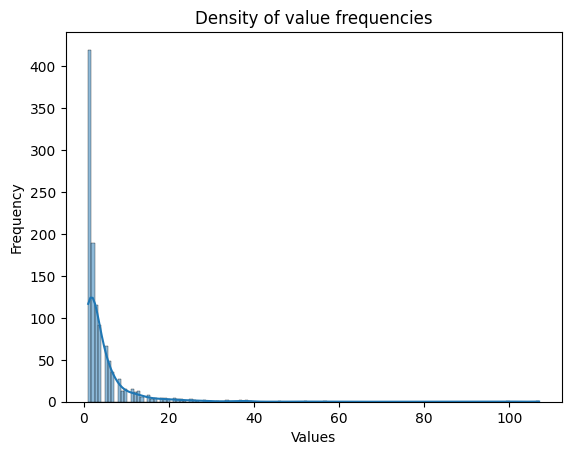

sellercity
Chicago         14.355635
Battle Creek    13.375551
Columbus         7.355034
Louisville       6.654974
Atlanta          5.814902
                  ...    
Midwest City    -0.485640
Ventura         -0.485640
New Haven       -0.485640
Cumming         -0.485640
Vincennes       -0.485640
Name: count, Length: 1129, dtype: float64


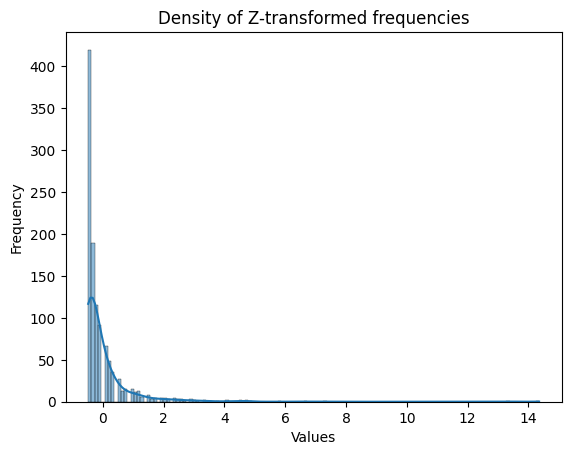

<Figure size 800x600 with 0 Axes>

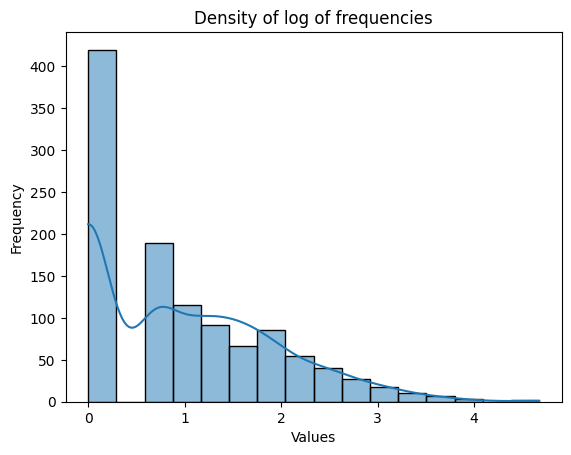

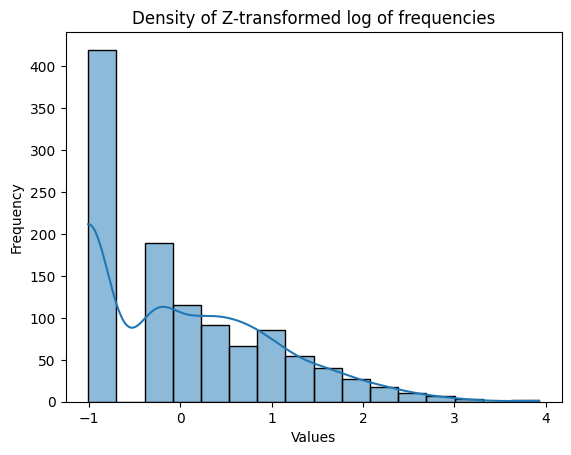

listingid
4777     21
6242      4
7108      7
10882     2
12013     7
Name: sellercity, dtype: int64

In [4030]:
value_counts = feat_ptr.value_counts()
# Plotting a histogram of frequencies (Frequencies of Frequencies)
plotDist(value_counts,"Density of value frequencies")
#FREQUENCY ENCODE THESE VALUES AND THEN TAKE Z SCORE OR THE FREQUENCIES
zvalues = zScoreTransform(value_counts)
print(zvalues)
plotDist(zvalues,"Density of Z-transformed frequencies")
# Assuming 'value_counts' contains the frequencies
log_frequencies = np.log(value_counts)
# Plotting the density plot of the log of frequencies
plt.figure(figsize=(8, 6))
plotDist(log_frequencies,"Density of log of frequencies")
# Plotting the density plot of the log of frequencies
zlog = zScoreTransform(log_frequencies)
plotDist(zlog,"Density of Z-transformed log of frequencies")
freq = feat_ptr.value_counts().to_dict()
feat_ptr = feat_ptr.map(freq)
feat_ptr.head()

In [4031]:
input_data[column] = feat_ptr
input_data.head()

,sellercity,sellerispriv,sellerlistsrc,sellername,sellerrating,sellerrevcnt,sellerstate,sellerzip,vehbodystyle,vehcertified,...,vehhistory,vehlistdays,vehmake,vehmileage,vehmodel,vehpricelabel,vehsellernotes,vehtype,vehtransmission,vehyear
listingid,,,,,,,,,,,,,,,,,,,,,
4777,21,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,True,...,"1 Owner, Buyback Protection Eligible",28.107014,Jeep,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015
6242,4,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,False,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",59.816875,Jeep,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018
7108,7,False,HomeNet Automotive,Superior Buick GMC of Fayetteville,3.7,74,AR,72703.0,SUV,False,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",98.665301,Cadillac,19788.0,XT5,Good Deal,"Luxury, Exterior Parking Camera Rear, Front Du...",Used,8-Speed Automatic,2018
10882,2,False,Digital Motorworks (DMi),Paul Brown Chrysler Dodge Jeep RAM Kia,3.0,51,NY,14760.0,SUV,False,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",30.967500,Jeep,34649.0,Grand Cherokee,Good Deal,Priced below KBB Fair Purchase Price! Clean CA...,Used,8-Speed Automatic,2018
12013,7,False,Digital Motorworks (DMi),Sierra Motor Mall,3.5,17,IL,61350.0,SUV,False,...,"1 Owner, Accident(s) Reported, Non-Personal Us...",194.482338,Jeep,48814.0,Grand Cherokee,Good Deal,2017 Jeep Grand Cherokee Laredo True Blue Pear...,Used,8-Speed Automatic,2017


In [4032]:

freq_cols.append(column)
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     False
6242     False
7108     False
10882    False
12013    False
Name: sellerispriv, dtype: bool

In [4033]:
feat_ptr.value_counts()

sellerispriv
False    5045
Name: count, dtype: int64

In [4034]:
feats_to_drop.append(column)

col+=1
feat_ptr,column = setFeatPtr(input_data,col)
print(feat_ptr.nunique())
feat_ptr.unique()

5


array(['Jeep Certified Program', 'Inventory Command Center',
       'HomeNet Automotive', 'Digital Motorworks (DMi)',
       'My Dealer Center'], dtype=object)

In [4035]:
#A CATEGORY COLUMN EASY TO ONE HOT ENCODE WITH A SMALL ENUMERATION AMOUNT (ONLY REQUIRES
# 3 COLUMNS TO ENCODE)
encoded_cols.append(column)
print(feat_ptr)
temp_df = oHotEncode(feat_ptr)
temp_df.head()

listingid
4777         Jeep Certified Program
6242       Inventory Command Center
7108             HomeNet Automotive
10882      Digital Motorworks (DMi)
12013      Digital Motorworks (DMi)
                     ...           
8614177    Digital Motorworks (DMi)
8615510    Digital Motorworks (DMi)
8616294    Digital Motorworks (DMi)
8617378    Digital Motorworks (DMi)
8620012          HomeNet Automotive
Name: sellerlistsrc, Length: 5045, dtype: object


,feature_Digital Motorworks (DMi),feature_HomeNet Automotive,feature_Inventory Command Center,feature_Jeep Certified Program,feature_My Dealer Center
listingid,,,,,
4777,0.0,0.0,0.0,1.0,0.0
6242,0.0,0.0,1.0,0.0,0.0
7108,0.0,1.0,0.0,0.0,0.0
10882,1.0,0.0,0.0,0.0,0.0
12013,1.0,0.0,0.0,0.0,0.0


In [4036]:

#DELETE ORIGINAL SELLER LIST SOURCE AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)

encoded_df = temp_df

In [4037]:
col+=1
feat_ptr,column = setFeatPtr(input_data,col)

In [4038]:
feat_ptr.head()

listingid
4777     Wilde Chrysler Jeep Dodge Ram &amp; Subaru
6242                Century Dodge Chrysler Jeep RAM
7108             Superior Buick GMC of Fayetteville
10882        Paul Brown Chrysler Dodge Jeep RAM Kia
12013                             Sierra Motor Mall
Name: sellername, dtype: object

In [4039]:
print(feat_ptr.value_counts()[feat_ptr.mode()]/len(feat_ptr))
feat_ptr.value_counts().head(30)

sellername
Vroom (Online Dealer - Nationwide Delivery)    0.063429
Name: count, dtype: float64


sellername
Vroom (Online Dealer - Nationwide Delivery)                320
Carvana                                                    236
Henkel Chrysler Dodge Jeep Ram                              98
Marino Chrysler Jeep Dodge RAM                              34
Barnett Chrysler Jeep Kia                                   33
Sewell Cadillac of Dallas                                   32
F.C. Kerbeck &amp; Sons                                     32
OffLeaseOnly.com The Nation&#x27;s Used Car Destination     30
Blue Knob Auto Sales                                        28
CarMax White Marsh                                          24
Cross Chrysler Jeep Fiat                                    23
Larry Roesch Dodge Chrysler Jeep RAM                        23
Park Chrysler Jeep                                          21
Germain Cadillac of Easton                                  20
Woody&#x27;s Dodge Jeep Chrysler RAM                        19
Sherman Dodge Chrysler Jeep RAM             

In [4040]:
#NOT ENOUGH VALUES, WILL NOT SIGNFICANTLY IMPACT MODEL PREDICTION EFFICIENCY

feats_to_drop.append(column)

In [4041]:
col +=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     4.8
6242     4.4
7108     3.7
10882    3.0
12013    3.5
Name: sellerrating, dtype: float64

In [4042]:
#POSSIBLY NORMALIZE (Z-TRANSFORM) FOR NOW KEEP IT INTACT

same_cols.append(column)
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     1405
6242       21
7108       74
10882      51
12013      17
Name: sellerrevcnt, dtype: int64

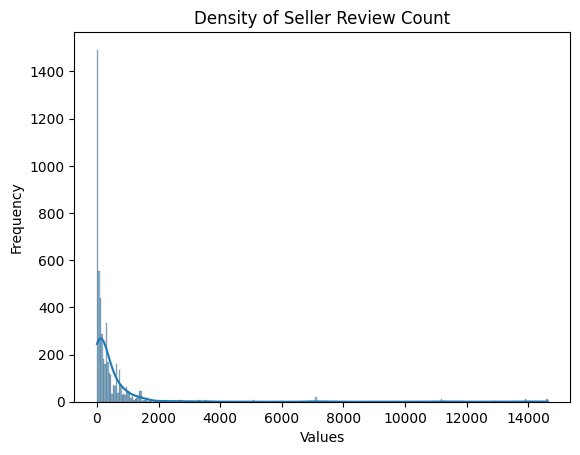

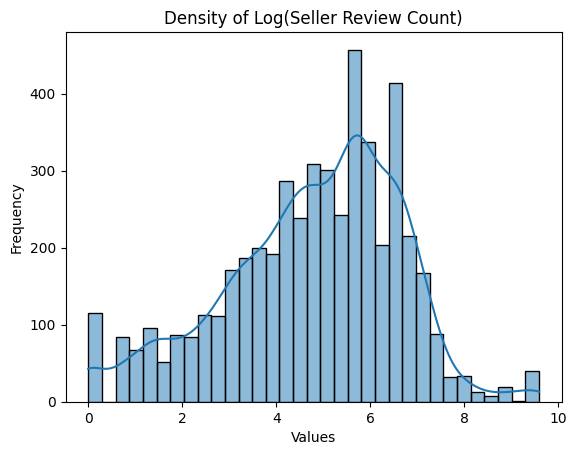

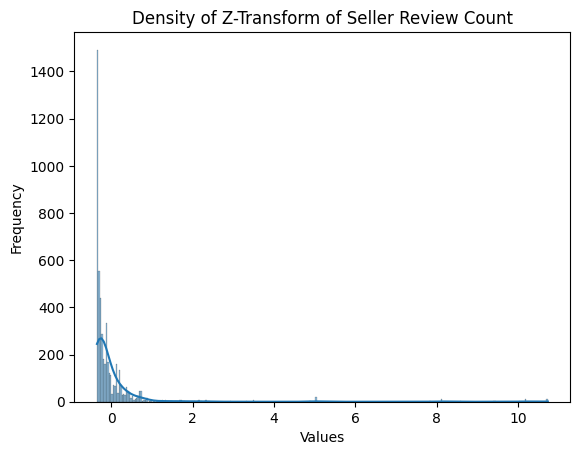

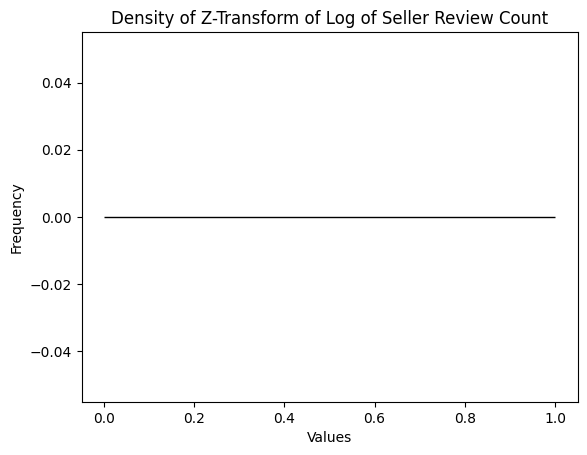

In [4043]:
plotDist(feat_ptr,'Density of Seller Review Count')
plotDist(np.log(feat_ptr),'Density of Log(Seller Review Count)')
plotDist(zScoreTransform(feat_ptr),'Density of Z-Transform of Seller Review Count')
plotDist(zScoreTransform(np.log(feat_ptr)),'Density of Z-Transform of Log of Seller Review Count')


In [4044]:
#KEEP REVIEW COUNT AS IS FOR NOW

same_cols.append(column)

col+=1 
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     WI
6242     MO
7108     AR
10882    NY
12013    IL
Name: sellerstate, dtype: object

In [4045]:
#STATES -> CATEGORICAL
temp_df = oHotEncode(feat_ptr)

#DROP ORIGINAL STATE COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)
encoded_cols.append(column)

In [4046]:
encoded_df.head()

,feature_Digital Motorworks (DMi),feature_HomeNet Automotive,feature_Inventory Command Center,feature_Jeep Certified Program,feature_My Dealer Center,feature_AK,feature_AL,feature_AR,feature_AZ,feature_CA,...,feature_SC,feature_SD,feature_TN,feature_TX,feature_UT,feature_VA,feature_VT,feature_WA,feature_WI,feature_WV
listingid,,,,,,,,,,,,,,,,,,,,,
4777,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6242,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7108,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10882,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12013,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4047]:
col+=1 
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.nunique()

1534

In [4048]:
#ZIP SEEMS REDUNDANT WITH CITY/STATE INFO ALREADY EXISTING
#PLUS THE AMOUNT OF VARYING ZIPS PROVIDES NOISY DATA

feats_to_drop.append(column)
print(feats_to_drop)

['sellerispriv', 'sellerlistsrc', 'sellername', 'sellerstate', 'sellerzip']


In [4049]:
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     SUV
6242     SUV
7108     SUV
10882    SUV
12013    SUV
Name: vehbodystyle, dtype: object

In [4050]:
feat_ptr.nunique()

1

In [4051]:
#ALL SUV, MEANINGLESS DATA

feats_to_drop.append(column)
col+=1

In [4052]:
feat_ptr, column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777      True
6242     False
7108     False
10882    False
12013    False
Name: vehcertified, dtype: bool

In [4053]:
#MASK BOOLEANS AS 1 AND 0's
feat_ptr = (feat_ptr).astype(int)
input_data[column] = feat_ptr

mask_cols.append(column)
col+=1

In [4054]:
feat_ptr, column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     Brilliant Black Crystal Pearlcoat
6242       Diamond Black Crystal Pearlcoat
7108               Radiant Silver Metallic
10882     Billet Silver Metallic Clearcoat
12013                  True Blue Pearlcoat
Name: vehcolorext, dtype: object

In [4055]:
feat_ptr.value_counts()

vehcolorext
Bright White Clearcoat               532
Brilliant Black Crystal Pearlcoat    337
Billet Silver Metallic Clearcoat     336
Stellar Black Metallic               295
Radiant Silver Metallic              247
                                    ... 
Silver Coast                           1
Ruby Red Metallic                      1
Silver Awd Pano Roof Loaded            1
Brilliant Silver                       1
Stellar Black M                        1
Name: count, Length: 142, dtype: int64

In [4056]:
temp_df = handleExtColors(feat_ptr)
temp_df.columns = temp_df.columns.str.lower()

#Merge two new columns with other existing multi-column encoded features
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)
#Want to drop original
feats_to_drop.append(column)
encoded_cols.append(column)
print(temp_df.sum())
print(temp_df[temp_df["none"]==1].index)

black        1254
blue          244
brown          55
green          14
metallic     1835
pearlcoat     819
clearcoat    1341
granite       641
red           535
silver       1059
white        1045
none          114
dtype: int64
Index([ 287172,  528899,  736178,  792826,  816014,  822663,  827114,  860178,
        989049,  993403,
       ...
       7977183, 7999952, 8001660, 8043488, 8147827, 8164007, 8182771, 8255035,
       8257649, 8400784],
      dtype='int64', name='listingid', length=114)


In [4057]:
col+=1
feat_ptr, column = setFeatPtr(input_data,col)
feat_ptr.value_counts().head(50)

vehcolorint
Black                                                 2716
Jet Black                                              747
Shara Beige                                            236
Sahara Beige                                           190
Cirrus                                                 131
Black Leather                                           96
black                                                   87
Light Frost                                             83
Maple Sugar                                             67
Brown                                                   54
Tan                                                     53
Lt Frost Beige/Black                                    53
Ruby Red/Black                                          47
Ruby Red                                                42
Light Frost/Brown                                       39
Light Frost Beige / Black                               32
jet black                                   

In [4058]:
temp_df = handleIntColors(feat_ptr)
temp_df.columns = temp_df.columns.str.lower()

#Merge two new columns with other existing multi-column encoded features
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)
#Want to drop original
feats_to_drop.append(column)
encoded_cols.append(column)
print(temp_df.sum())
print(temp_df[temp_df["none"]==1].index)

black      3957
blue         18
brown       168
beige       605
leather     125
trim         11
red         110
silver       41
frost       283
maple        68
tan          58
cirrus      136
carbon       17
plum         15
none         21
dtype: int64
Index([ 903203, 1491106, 2000241, 2028388, 2102637, 2585204, 2729520, 2842810,
       3198504, 3409549, 4761924, 4833074, 4904298, 5102938, 5252166, 5538849,
       6022159, 6400857, 6475088, 7504666, 8084993],
      dtype='int64', name='listingid')


In [4059]:
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     4x4/4WD
6242         4WD
7108         FWD
10882        4WD
12013        4WD
Name: vehdrivetrain, dtype: object

In [4060]:
feat_ptr.value_counts()

vehdrivetrain
4WD                                                           3341
FWD                                                            950
AWD                                                            630
4X4                                                             32
Four Wheel Drive                                                30
All Wheel Drive                                                 18
Front Wheel Drive                                               16
4x4/4WD                                                          9
4x4                                                              6
AWD or 4x4                                                       6
All-wheel Drive                                                  3
ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL       1
ALL WHEEL                                                        1
AllWheelDrive                                                    1
4WD/AWD                                         

In [4061]:
#BASED OFF UNIQUE VALUES SEPERATE INTO 4WD,FWD,or AWD
feat_ptr = handleDriveTrain(feat_ptr)
feat_ptr.value_counts()

vehdrivetrain
4wd       3418
fwd        966
awd        654
hybrid       7
Name: count, dtype: int64

In [4062]:
temp_df = oHotEncode(feat_ptr)
#DROP ORIGINAL STATE COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)
encoded_cols.append(column)

col+=1
temp_df

,feature_4wd,feature_awd,feature_fwd,feature_hybrid
listingid,,,,
4777,1.0,0.0,0.0,0.0
6242,1.0,0.0,0.0,0.0
7108,0.0,0.0,1.0,0.0
10882,1.0,0.0,0.0,0.0
12013,1.0,0.0,0.0,0.0
...,...,...,...,...
8614177,1.0,0.0,0.0,0.0
8615510,1.0,0.0,0.0,0.0
8616294,0.0,0.0,1.0,0.0


In [4063]:
feat_ptr, column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehengine
3.6L V6 24V MPFI DOHC                  1569
3.6L V6 24V GDI DOHC                    920
Regular Unleaded V-6 3.6 L/220          555
Gas V6 3.6L/222.6                       364
3.6L V6 24V MPFI DOHC Flexible Fuel     301
                                       ... 
5.7L V8 OHV 16V                           1
V6 3.6L Natural Aspiration                1
6.4L 8 Cylinder Engine                    1
6.4L V8                                   1
6.2L 8 Cyl.                               1
Name: count, Length: 82, dtype: int64

In [4064]:
#handleVehEngine takes the vehEngine column and turns it into a 
#2 column data frame by splitting the phrases into engine size 
#and cyclinder configuration
temp_df = handleVehEngine(feat_ptr)
print(temp_df["EngineSize"].value_counts())
print(temp_df["Cylinders"].value_counts())
# '0' represents unknown for either columns

EngineSize
3.6    4579
5.7     198
0.0     145
6.4      63
3.0      37
6.2      23
Name: count, dtype: int64
Cylinders
6    4653
8     279
0     113
Name: count, dtype: int64


In [4065]:

#Merge two new columns with other existing multi-column encoded features
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)
#Want to drop original
feats_to_drop.append(column)
encoded_cols.append(column)
col+=1
temp_df.head()

,EngineSize,Cylinders
listingid,,
4777,3.6,6
6242,3.6,6
7108,3.6,6
10882,3.6,6
12013,3.6,6


In [4066]:
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     ['18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capa...
6242     ['Android Auto', 'Antilock Brakes', 'Apple Car...
7108     ['4-Wheel Disc Brakes', 'ABS', 'Adjustable Ste...
10882    ['1st and 2nd row curtain head airbags', '4-wh...
12013    ['1st and 2nd row curtain head airbags', '4-wh...
Name: vehfeats, dtype: object

In [4067]:
#ELIMINATE WORDS THAT APPEAR IN MORE THAN max_doc_freq OF DOCUMENTS (DOCUMENT ~ ROW)
#WILL GET RID OF COMMON WORDS SUCH AS "THE", "A", etc.
#LIMIT VOCABULARY TO max_feats COLUMNS (ONE FOR EACH WORD)
temp_df = tf_idfTokenizer(feat_ptr,max_doc_freq=.50,max_feats=60)
#THOUGHT: TUNE THE HYPERPARAMETERS TO OPTIMIZE THE TOKENIZER?
temp_df.head()

,adjustable,air,alarm,alloy,aluminum,am,android,anti,antilock,apple,...,slot,speakers,spot,stereo,studio,surround,theft,trim,wheels,wireless
listingid,,,,,,,,,,,,,,,,,,,,,
4777,0.333366,0.000000,0.000000,0.0,0.257913,0.235506,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.0,0.316452,0.000000,0.000000,0.00000,0.0,0.238253,0.0
6242,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.32891,0.00000,0.274586,0.331692,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0
7108,0.285374,0.000000,0.000000,0.0,0.220784,0.201603,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.0,0.270895,0.300044,0.592295,0.00000,0.0,0.203954,0.0
10882,0.000000,0.000000,0.306975,0.0,0.000000,0.000000,0.00000,0.29752,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.30753,0.0,0.000000,0.0
12013,0.000000,0.273587,0.000000,0.0,0.000000,0.241295,0.00000,0.00000,0.000000,0.000000,...,0.238766,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0


In [4068]:

#DROP ORIGINAL STATE COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
encoded_cols.append(column)
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)

col+=1

In [4069]:
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehfuel
Gasoline         4695
E85 Flex Fuel     310
Diesel             35
Unknown             5
Name: count, dtype: int64

In [4070]:

temp_df = oHotEncode(feat_ptr)
temp_df.head()

,feature_Diesel,feature_E85 Flex Fuel,feature_Gasoline,feature_Unknown
listingid,,,,
4777,0.0,0.0,1.0,0.0
6242,0.0,0.0,1.0,0.0
7108,0.0,0.0,1.0,0.0
10882,0.0,0.0,1.0,0.0
12013,0.0,0.0,1.0,0.0


In [4071]:
#DROP ORIGINAL COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
encoded_cols.append(column)
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)
col+=1

In [4072]:
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

temp_df = feat_ptr.str.split(',',n=1,expand=True)
temp_df.columns = ['Owners', 'History']
temp_df["History"].unique()

array([' Buyback Protection Eligible',
       ' Non-Personal Use Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported',
       ' Title Issue(s) Reported',
       ' Accident(s) Reported, Title Issue(s) Reported',
       ' Title Issue(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       ' Non-Personal Use Reported, Title Issue(s) Reported',
       ' Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       None], dtype=object)

In [4073]:
temp_df['Owners'] = temp_df['Owners'].str.extract(r'^(\d+)')
temp_df['Owners'].head()

listingid
4777     1
6242     1
7108     1
10882    1
12013    1
Name: Owners, dtype: object

In [4074]:
temp_df["History"].value_counts()

History
 Buyback Protection Eligible                                                                              2655
 Non-Personal Use Reported, Buyback Protection Eligible                                                   1782
 Accident(s) Reported, Buyback Protection Eligible                                                         236
 Accident(s) Reported, Non-Personal Use Reported, Buyback Protection Eligible                              165
 Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported                                  113
 Title Issue(s) Reported                                                                                    40
 Accident(s) Reported, Title Issue(s) Reported                                                              22
 Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible       7
 Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible                        

In [4075]:
#TURNS OUT THAT THESE PHRASES CAN ACTUALLY BE TURNED INTO CATEGORICAL COLUMNS
#EACH ELEMENT IS A COMBINATION OF VARYING SIZE OF THE 4 POSSIBLE UNIQUE PHRASES
#ONE HOT ENCODE WITH A COLUMN FOR EACH PHRASE
encoded_hist = handleVehHistory(temp_df["History"])
encoded_hist.head()

,Accident(s) Reported,Buyback Protection Eligible,Non-Personal Use Reported,Title Issue(s) Reported,None of the above
listingid,,,,,
4777,0,1,0,0,0
6242,0,0,1,0,0
7108,0,0,1,0,0
10882,0,0,1,0,0
12013,1,0,0,0,0


In [4076]:

#DROP ORIGINAL COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
encoded_cols.append(column)
encoded_df = pd.merge(encoded_df, encoded_hist, left_index=True, right_index=True)
encoded_df.head()

,feature_Digital Motorworks (DMi),feature_HomeNet Automotive,feature_Inventory Command Center,feature_Jeep Certified Program,feature_My Dealer Center,feature_AK,feature_AL,feature_AR,feature_AZ,feature_CA,...,wireless,feature_Diesel,feature_E85 Flex Fuel,feature_Gasoline,feature_Unknown,Accident(s) Reported,Buyback Protection Eligible,Non-Personal Use Reported,Title Issue(s) Reported,None of the above
listingid,,,,,,,,,,,,,,,,,,,,,
4777,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0
6242,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0
7108,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0
10882,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0
12013,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0


In [4077]:
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777      28.107014
6242      59.816875
7108      98.665301
10882     30.967500
12013    194.482338
Name: vehlistdays, dtype: float64

In [4078]:
#Use ceiling in order to round to whole days and start the listings 
#on day 1 rather than day 0
feat_ptr = pd.Series(np.ceil(feat_ptr),index=feat_ptr.index)
feat_ptr.head()

listingid
4777      29.0
6242      60.0
7108      99.0
10882     31.0
12013    195.0
Name: vehlistdays, dtype: float64

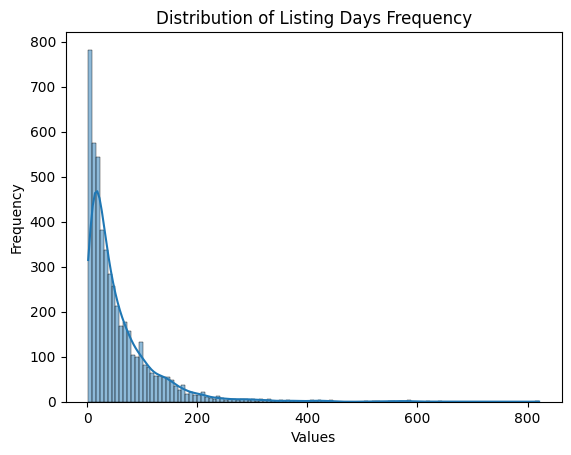

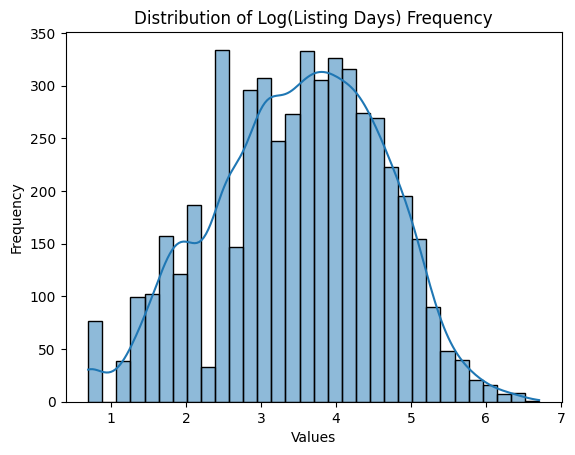

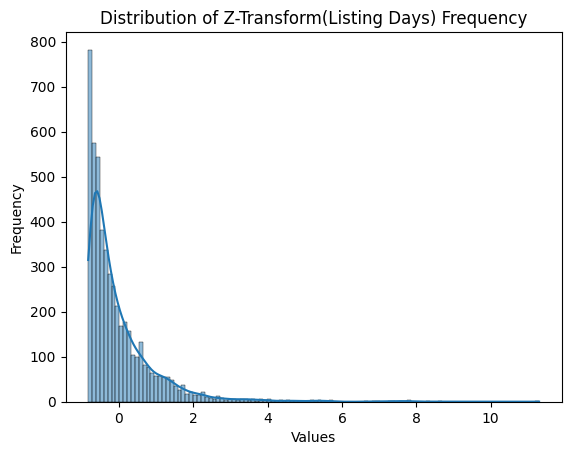

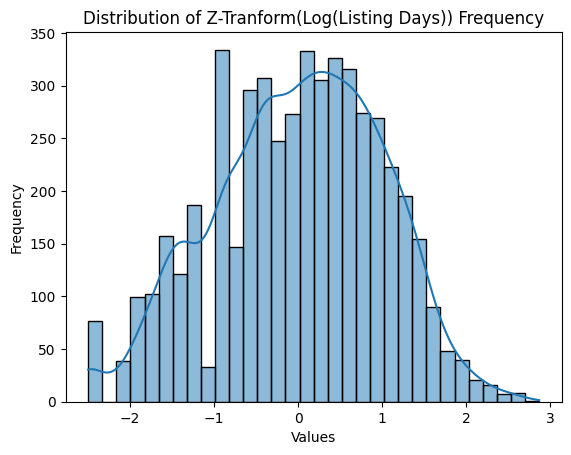

In [4079]:
plotDist(feat_ptr,"Distribution of Listing Days Frequency")
plotDist(np.log(feat_ptr),"Distribution of Log(Listing Days) Frequency")
plotDist(zScoreTransform(feat_ptr),"Distribution of Z-Transform(Listing Days) Frequency")
plotDist(zScoreTransform(np.log(feat_ptr)),"Distribution of Z-Tranform(Log(Listing Days)) Frequency")


In [4080]:
#CHOOSE LOG VALUE
feat_ptr = np.log(feat_ptr)
feat_ptr.head()

listingid
4777     3.367296
6242     4.094345
7108     4.595120
10882    3.433987
12013    5.273000
Name: vehlistdays, dtype: float64

In [4081]:
input_data[column] = feat_ptr
log_cols.append(column)

col+=1
input_data.head()

,sellercity,sellerispriv,sellerlistsrc,sellername,sellerrating,sellerrevcnt,sellerstate,sellerzip,vehbodystyle,vehcertified,...,vehhistory,vehlistdays,vehmake,vehmileage,vehmodel,vehpricelabel,vehsellernotes,vehtype,vehtransmission,vehyear
listingid,,,,,,,,,,,,,,,,,,,,,
4777,21,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,1,...,"1 Owner, Buyback Protection Eligible",3.367296,Jeep,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015
6242,4,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,0,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",4.094345,Jeep,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018
7108,7,False,HomeNet Automotive,Superior Buick GMC of Fayetteville,3.7,74,AR,72703.0,SUV,0,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",4.595120,Cadillac,19788.0,XT5,Good Deal,"Luxury, Exterior Parking Camera Rear, Front Du...",Used,8-Speed Automatic,2018
10882,2,False,Digital Motorworks (DMi),Paul Brown Chrysler Dodge Jeep RAM Kia,3.0,51,NY,14760.0,SUV,0,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",3.433987,Jeep,34649.0,Grand Cherokee,Good Deal,Priced below KBB Fair Purchase Price! Clean CA...,Used,8-Speed Automatic,2018
12013,7,False,Digital Motorworks (DMi),Sierra Motor Mall,3.5,17,IL,61350.0,SUV,0,...,"1 Owner, Accident(s) Reported, Non-Personal Us...",5.273000,Jeep,48814.0,Grand Cherokee,Good Deal,2017 Jeep Grand Cherokee Laredo True Blue Pear...,Used,8-Speed Automatic,2017


In [4082]:
feat_ptr, column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777         Jeep
6242         Jeep
7108     Cadillac
10882        Jeep
12013        Jeep
Name: vehmake, dtype: object

In [4083]:
temp_df = oHotEncode(feat_ptr)

#DROP ORIGINAL COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)
encoded_cols.append(column)
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     38957.0
6242     20404.0
7108     19788.0
10882    34649.0
12013    48814.0
Name: vehmileage, dtype: float64

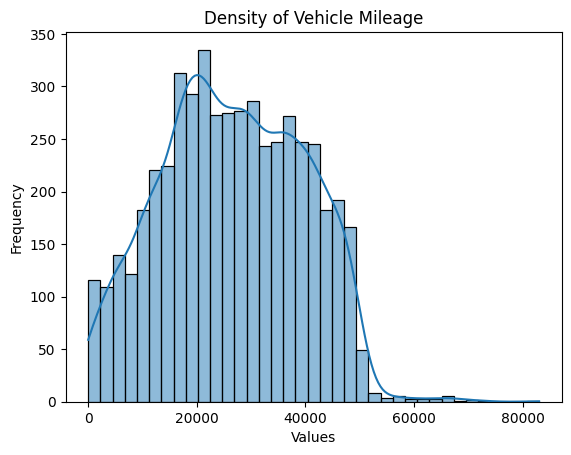

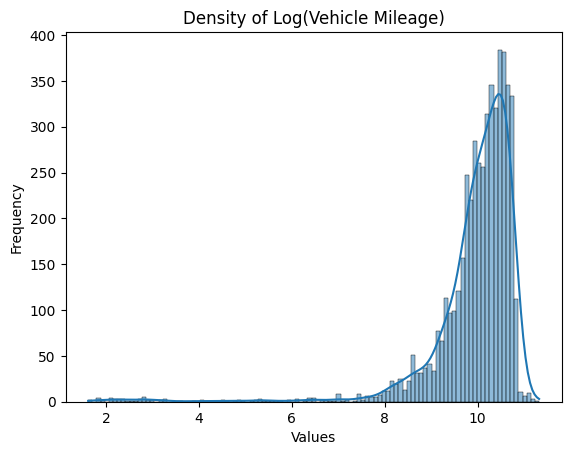

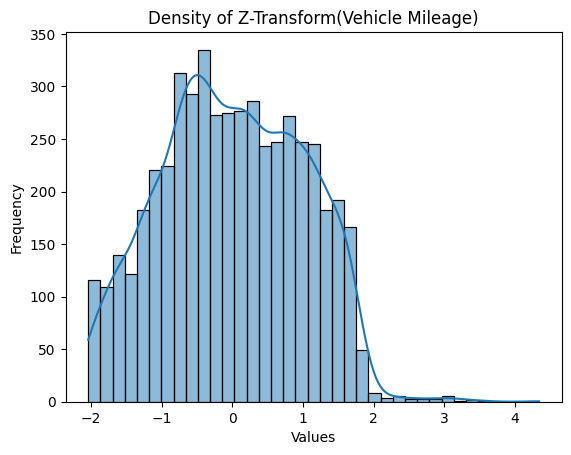

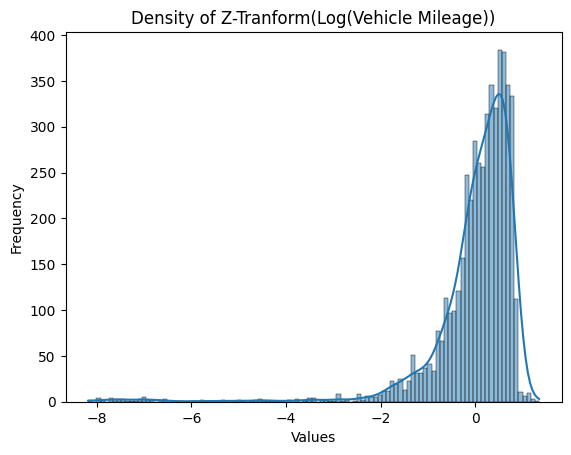

In [4084]:
plotDist(feat_ptr,"Density of Vehicle Mileage")
plotDist(np.log(feat_ptr),"Density of Log(Vehicle Mileage)")
plotDist(zScoreTransform(feat_ptr),"Density of Z-Transform(Vehicle Mileage)")
plotDist(zScoreTransform(np.log(feat_ptr)),"Density of Z-Tranform(Log(Vehicle Mileage))")

In [4085]:
#ORIGINAL DATA LOOKS ~NORMAL~

same_cols.append(column)
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     Grand Cherokee
6242     Grand Cherokee
7108                XT5
10882    Grand Cherokee
12013    Grand Cherokee
Name: vehmodel, dtype: object

In [4086]:
#ALREADY HAVE JEEP/CADILLAC ENCODED COLUMNS WHICH HAVE A DIRECT CORRELATION TO THIS
#WILL REMOVE THIS EXTRANEOUS COLUMN
feats_to_drop.append(column)


col+=1 
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehpricelabel
Good Deal     3752
Great Deal     731
Fair Price     562
Name: count, dtype: int64

In [4087]:
temp_df = oHotEncode(feat_ptr)

#DROP ORIGINAL COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)
encoded_cols.append(column)

col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     Backed by a rigorous 125-point inspection by f...
6242     Drop by to see us and you will quickly see how...
7108     Luxury, Exterior Parking Camera Rear, Front Du...
10882    Priced below KBB Fair Purchase Price! Clean CA...
12013    2017 Jeep Grand Cherokee Laredo True Blue Pear...
Name: vehsellernotes, dtype: object

In [4088]:
#ELIMINATE WORDS THAT APPEAR IN MORE THAN max_doc_freq OF DOCUMENTS (DOCUMENT ~ ROW)
#WILL GET RID OF COMMON WORDS SUCH AS "THE", "A", etc.
#LIMIT VOCABULARY TO max_feats COLUMNS (ONE FOR EACH WORD)
temp_df = tf_idfTokenizer(feat_ptr,max_doc_freq=.50,max_feats=50)
#THOUGHT: TUNE THE HYPERPARAMETERS TO OPTIMIZE THE TOKENIZER?
temp_df.head()

,4wd,6l,all,amp,automatic,br,cadillac,call,camera,car,...,that,this,us,v6,vehicles,warranty,wheel,x27,x3d,your
listingid,,,,,,,,,,,,,,,,,,,,,
4777,0.000000,0.000000,0.176378,0.000000,0.000000,0.0,0.0,0.180669,0.000000,0.000000,...,0.211763,0.325770,0.360489,0.000000,0.000000,0.187169,0.000000,0.177741,0.0,0.157799
6242,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.562847,0.000000,0.000000,0.000000,0.000000,0.555027,0.0,0.000000
7108,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.118109,0.230756,...,0.144598,0.111223,0.246153,0.000000,0.119489,0.000000,0.118945,0.242733,0.0,0.323249
10882,0.159268,0.140598,0.000000,0.000000,0.129516,0.0,0.0,0.000000,0.000000,0.133454,...,0.000000,0.000000,0.000000,0.133257,0.000000,0.147828,0.000000,0.000000,0.0,0.124631
12013,0.144315,0.000000,0.378678,0.159241,0.117356,0.0,0.0,0.000000,0.123787,0.000000,...,0.151550,0.349709,0.000000,0.000000,0.000000,0.133949,0.124663,0.254403,0.0,0.112930


In [4089]:

#DROP ORIGINAL STATE COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)
encoded_cols.append(column)

col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehtype
Used    5045
Name: count, dtype: int64

In [4090]:
#ENTIRE COLUMN HAS VALUE "USED".....  DROPPING....
feats_to_drop.append(column)


col+=1 
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehtransmission
8-Speed Automatic                3824
8-Speed Automatic w/OD            599
Automatic                         273
AUTOMATIC                          69
Automatic 8-Speed                  63
8-Speed Shiftable Automatic        62
8-Speed Automatic (845RE)          48
8-Speed A/T                        44
8-Speed Automatic (850RE)          11
8-Speed                            11
8-Spd TorqueFlite Automatic         7
8 Speed Automatic                   7
8-Speed Automatic (8HP70)           5
Automatic, 8-Spd                    4
8-SPEED AUTOMATIC                   3
Not Specified                       2
6-Speed Automatic                   2
8 speed automatic                   2
A                                   1
automatic                           1
8-Spd Auto 850RE Trans (Make)       1
8-Spd Auto 850RE Trans (Make        1
aujtomatic                          1
Automatic w/OD                      1
8-Speed TorqueFlite Automatic       1
AUTO                              

In [4091]:
#BASICALLY ALL 8-SPEED SO IT GETS DROPPED
feats_to_drop.append(column)


col+=1 
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehyear
2018    1662
2017    1609
2015    1278
2016     384
2019     112
Name: count, dtype: int64

In [4092]:
#ONLY 5 UNIQUES IN OUR DATASET SO WE WILL ONE HOT ENCODE THE CATEGORIES
temp_df = oHotEncode(feat_ptr)

#DROP ORIGINAL COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
encoded_cols.append(column)
encoded_df = pd.merge(encoded_df, temp_df, left_index=True, right_index=True)
temp_df.head()

,feature_2015,feature_2016,feature_2017,feature_2018,feature_2019
listingid,,,,,
4777,1.0,0.0,0.0,0.0,0.0
6242,0.0,0.0,0.0,1.0,0.0
7108,0.0,0.0,0.0,1.0,0.0
10882,0.0,0.0,0.0,1.0,0.0
12013,0.0,0.0,1.0,0.0,0.0


In [4093]:
feats_handled = (log_cols+encoded_cols+freq_cols+same_cols+mask_cols)
input_data.drop(columns=feats_to_drop,inplace=True)
print(set(feats_handled)-set(input_data.columns)-set(encoded_cols))
print(encoded_cols)
input_data.head()

set()
['sellerlistsrc', 'sellerstate', 'vehcolorext', 'vehcolorint', 'vehdrivetrain', 'vehengine', 'vehfeats', 'vehfuel', 'vehhistory', 'vehmake', 'vehpricelabel', 'vehsellernotes', 'vehyear']


,sellercity,sellerrating,sellerrevcnt,vehcertified,vehlistdays,vehmileage
listingid,,,,,,
4777,21,4.8,1405,1,3.367296,38957.0
6242,4,4.4,21,0,4.094345,20404.0
7108,7,3.7,74,0,4.595120,19788.0
10882,2,3.0,51,0,3.433987,34649.0
12013,7,3.5,17,0,5.273000,48814.0


In [4094]:
post_feat_eng = pd.merge(input_data,encoded_df,left_index=True, right_index=True)
post_feat_eng

,sellercity,sellerrating,sellerrevcnt,vehcertified,vehlistdays,vehmileage,feature_Digital Motorworks (DMi),feature_HomeNet Automotive,feature_Inventory Command Center,feature_Jeep Certified Program,...,warranty,wheel,x27,x3d,your,feature_2015,feature_2016,feature_2017,feature_2018,feature_2019
listingid,,,,,,,,,,,,,,,,,,,,,
4777,21,4.8,1405,1,3.367296,38957.0,0.0,0.0,0.0,1.0,...,0.187169,0.000000,0.177741,0.0,0.157799,1.0,0.0,0.0,0.0,0.0
6242,4,4.4,21,0,4.094345,20404.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.555027,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
7108,7,3.7,74,0,4.595120,19788.0,0.0,1.0,0.0,0.0,...,0.000000,0.118945,0.242733,0.0,0.323249,0.0,0.0,0.0,1.0,0.0
10882,2,3.0,51,0,3.433987,34649.0,1.0,0.0,0.0,0.0,...,0.147828,0.000000,0.000000,0.0,0.124631,0.0,0.0,0.0,1.0,0.0
12013,7,3.5,17,0,5.273000,48814.0,1.0,0.0,0.0,0.0,...,0.133949,0.124663,0.254403,0.0,0.112930,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8614177,57,1.5,6,0,3.688879,35773.0,1.0,0.0,0.0,0.0,...,0.259661,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
8615510,28,3.3,16,0,1.609438,20039.0,1.0,0.0,0.0,0.0,...,0.269844,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
8616294,5,4.1,20,1,5.220356,16278.0,1.0,0.0,0.0,0.0,...,0.466435,0.000000,0.147646,0.0,0.393242,0.0,0.0,0.0,1.0,0.0


In [4095]:
output_data = pd.DataFrame(df_train.iloc[:,-2:].copy())
output_data.head(5)

,vehicle_trim,dealer_listing_price
listingid,,
4777,Laredo,23249.0
6242,Limited,31977.0
7108,Luxury,33495.0
10882,Limited,27900.0
12013,Laredo,22989.0


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 15],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(input_data,output_data.iloc[:,1])
best_est = grid_search.best_estimator_

output_feat = output_data.columns[1]

fig, axes = plt.subplots(nrows=1, ncols=len(input_data.columns), figsize=(18, 4))

for i, feat in enumerate(input_data.columns):
    pdp_dist = pdp.pdp_isolate(model=best_est, dataset=X_regression_test, 
                               model_features=input_data.columns, feature=feat)
    pdp.pdp_plot(pdp_dist, feature_name, plot_lines=True, frac_to_plot=100, ax=axes[i])
    axes[i].set_title(f'PDP for {feature_name}')
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel(output_feature_name_regression)

plt.tight_layout()
plt.show()

AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_isolate'

In [ ]:
if __name__ == "__main__":
    print("SETTING UP.....")
    #wrn.filterwarnings('ignore', category=SettingWithCopyWarning )
    df_train = pd.read_csv('Training_DataSet.csv')
    df_test = pd.read_csv('Test_Dataset.csv')
    
    df_train.dropna(axis=0,how='any',inplace=True)
    
    #SETUP TRAINING AND TEST INPUT DATAFRAMES
    x_train = preprocessInput(df_train,True)
    x_test = preprocessInput(df_test) 
    print(x_train)
    x_train.to_csv("xtr.csv")
    quit()
    
    #SET LABELS TO PREDICT IN Y DATAFRAME
    y_train = df_train[getOutputFeatures()]   
    

    
    # for oh in one_hot_cols:
    #     x_train[oh] = one_hot_encoder.fit_transform(x_train[[oh]]).toarray()
    #     x_test[oh] = one_hot_encoder.fit_transform(x_test[[oh]]).toarray()
    

In [ ]:
    param_grid_knn = {
        'n_neighbors': [3, 5, 10,15],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2],
        'n_jobs': [-1]
    }
    print("RUNNING REGRESSION....")
    knn = KNeighborsRegressor()
    knn_cv = GridSearchCV(knn, param_grid_knn,cv=10)
    knn_cv.fit(x_train,y_train.iloc[:,1])
    pred_price = knn_cv.best_estimator_.predict(x_test)
    
    #bayes = BayesSearchCV()
    
    param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt'],
        'n_jobs':[-1]
    }
    
    print("RUNNING CLASSIFICATION.....")
    rf_class = RandomForestClassifier()
    rf_cv = GridSearchCV(rf_class, param_grid_rf,cv=5)
    rf_cv.fit(x_train,y_train.iloc[:,0])
    pred_trim = rf_cv.best_estimator_.predict(x_test)

    df_preds = x_test.copy()
    df_preds[output_columns[0]] = pred_trim
    df_preds[output_columns[1]] = pred_price
    df_preds.to_csv("Predictions.csv")